<a href="https://colab.research.google.com/github/ManjunathD620/Conditional_GAN/blob/main/HandWirttenDigits_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
x_train.shape[0]

60000

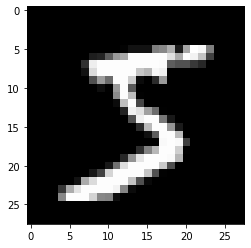

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0],cmap='gray')

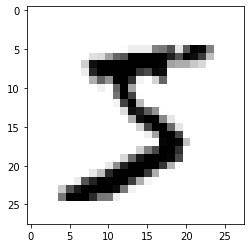

In [ ]:
plt.imshow(x_train[0],cmap='gray_r')

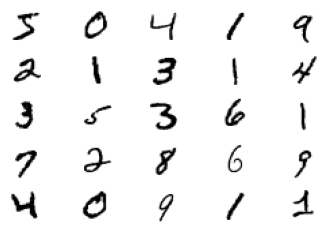

In [ ]:
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(x_train[i],cmap="gray_r")

plt.show();
  

In [ ]:

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model


# define the standalone discriminator model
def discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model = discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


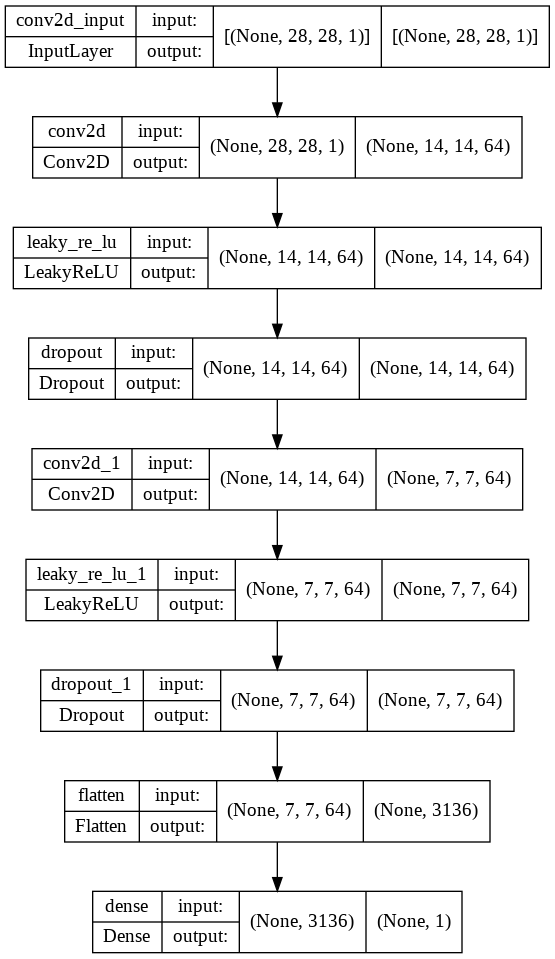

In [ ]:
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
x_train[0].shape[0]

28

In [ ]:
import numpy as np
x_train[[2,3,23]].shape

(3, 28, 28)

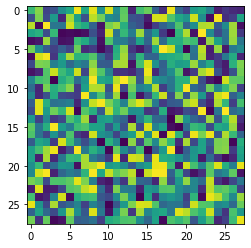

In [ ]:
a = np.random.rand(28*28*2)
a = a.reshape((2,28,28,1))
plt.imshow(a[0].reshape(28,28))

In [ ]:
def generate_real_sample(n_sample):
  a = x_train
  a = np.expand_dims(a,axis = -1)
  a = a.astype('float32')
  a = a/255.0

  r = np.random.randint(0, x_train.shape[0], n_sample)

  x = a[r]
  y = np.ones((n_sample,1))
  return x,y

In [ ]:
def generate_fake_sample(n_sample):
  b = np.random.rand(28*28*n_sample)
  b = b.reshape((n_sample,28,28,1))
  y = np.zeros((n_sample,1))
  return b,y

In [ ]:
def train_descriminator(model,batch = 256, epoch = 10):
  for i in range(epoch):
    x_real,y_real =  generate_real_sample(int(batch/2))
    _, real_acc = model.train_on_batch(x_real,y_real)

    x_fake,y_fake = generate_fake_sample(batch//2)
    _,fake_acc = model.train_on_batch(x_fake,y_fake)

    print(f">{i+1} real accuracy = {real_acc} and fake accuracy = {fake_acc}")

In [ ]:
train_descriminator(model)

>1 real accuracy = 0.671875 and fake accuracy = 0.2265625
>2 real accuracy = 0.7890625 and fake accuracy = 0.3515625
>3 real accuracy = 0.6953125 and fake accuracy = 0.6640625
>4 real accuracy = 0.71875 and fake accuracy = 0.7578125
>5 real accuracy = 0.7109375 and fake accuracy = 0.8828125
>6 real accuracy = 0.6640625 and fake accuracy = 0.96875
>7 real accuracy = 0.5703125 and fake accuracy = 0.9921875
>8 real accuracy = 0.6171875 and fake accuracy = 0.984375
>9 real accuracy = 0.6875 and fake accuracy = 1.0
>10 real accuracy = 0.6328125 and fake accuracy = 1.0


In [ ]:
from keras.layers import Conv2DTranspose,Reshape,Dense,LeakyReLU,Conv2D
from keras.models import Sequential
def build_generator(latent):
  model = Sequential()
  model.add(Dense(128 * 7 * 7,input_dim=latent))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha = 0.2))

  
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Conv2D(1,(7,7),activation="sigmoid",padding='same'))

  return model

In [ ]:
def gan_model(d_model,g_model):
  model = Sequential()

  d_model.trainable = False


  model.add(g_model)
  model.add(d_model)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt) 
  return model

In [ ]:
def generate_fake_data(n_sample,laten_dim,model):
  a = np.random.randn(n_sample*laten_dim)
  a = a.reshape(n_sample,laten_dim)
  x = model.predict(a)

  y = np.zeros((n_sample,1))

  return x,y

In [ ]:
def plot_images(examples, epoch, n=10):

  print("fuck")
  for i in range(n*2):
   plt.subplot(5,4, 1 + i) 
   plt.axis('off') 
   plt.imshow(examples[i].reshape(28,28), cmap='gray_r')
  
  plt.show()

In [ ]:
def train_gan(g_model,d_model,gan_model,epoch=100,batch =256):
  B_size = 68000//256

  for i in range(epoch):
    for j in range(B_size):
      x_real,y_real = generate_real_sample(batch)
      x_fake,y_fake = generate_fake_data(batch,100,g_model)
      x,y = np.vstack((x_real,x_fake)),np.vstack((y_real,y_fake))
      d_loss , _ = d_model.train_on_batch(x,y)

      l = np.random.randn(batch*100)
      x_gan = l.reshape(batch,100)
      y_gan = np.ones((batch,1))
      g = gan_model.train_on_batch(x_gan,y_gan)

    if(i %2 == 0):
      test(g_model,d_model)

In [ ]:
def test(g_model,d_model):
  x_fake,y_fake = generate_fake_data(30,100,g_model)
  _,acc = d_model.evaluate(x_fake,y_fake)
  print(f"Accuracy = {acc}")
  plot_images(x_fake,0)

In [ ]:
g = build_generator(100)
d = discriminator()
gan = gan_model(d,g)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 102ms/step - loss: 0.6753 - accuracy: 0.5667
Accuracy = 0.5666666626930237
fuck


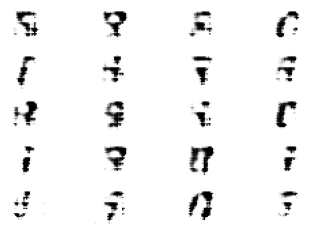

1/1 [==============================] - 0s 26ms/step - loss: 0.7637 - accuracy: 0.0667
Accuracy = 0.06666667014360428
fuck


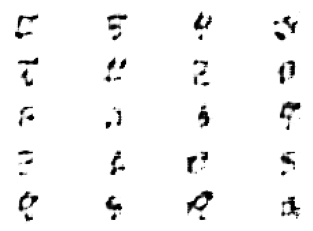

1/1 [==============================] - 0s 18ms/step - loss: 0.7119 - accuracy: 0.3000
Accuracy = 0.30000001192092896
fuck


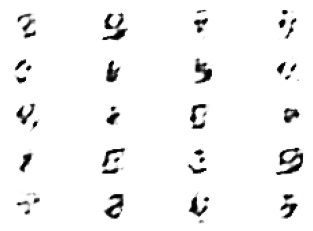

1/1 [==============================] - 0s 17ms/step - loss: 0.6555 - accuracy: 0.7667
Accuracy = 0.7666666507720947
fuck


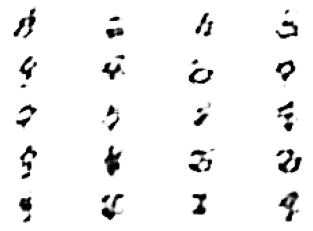

1/1 [==============================] - 0s 20ms/step - loss: 0.6863 - accuracy: 0.5667
Accuracy = 0.5666666626930237
fuck


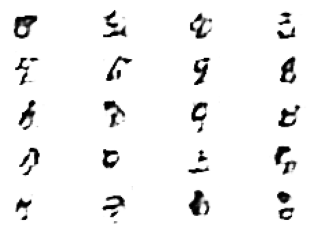

1/1 [==============================] - 0s 17ms/step - loss: 0.7126 - accuracy: 0.2000
Accuracy = 0.20000000298023224
fuck


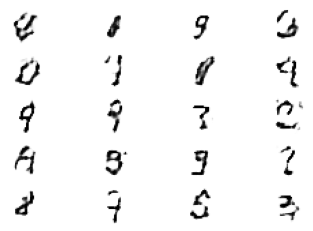

1/1 [==============================] - 0s 17ms/step - loss: 0.6989 - accuracy: 0.3667
Accuracy = 0.36666667461395264
fuck


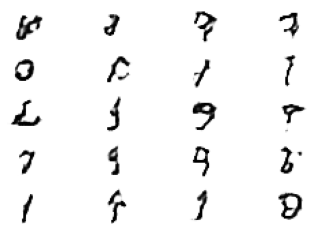

1/1 [==============================] - 0s 18ms/step - loss: 0.6824 - accuracy: 0.6333
Accuracy = 0.6333333253860474
fuck


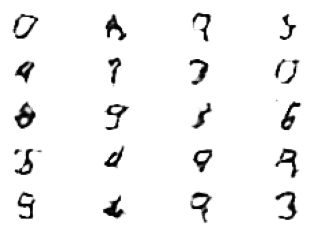

1/1 [==============================] - 0s 20ms/step - loss: 0.6915 - accuracy: 0.6667
Accuracy = 0.6666666865348816
fuck


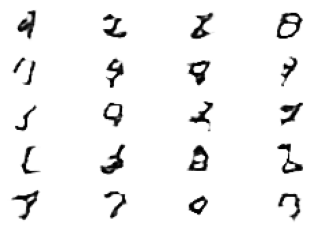

1/1 [==============================] - 0s 22ms/step - loss: 0.6987 - accuracy: 0.4000
Accuracy = 0.4000000059604645
fuck


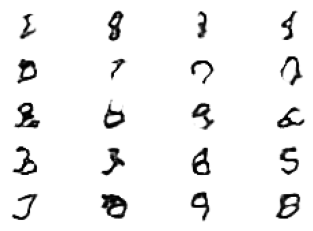

1/1 [==============================] - 0s 20ms/step - loss: 0.6816 - accuracy: 0.7667
Accuracy = 0.7666666507720947
fuck


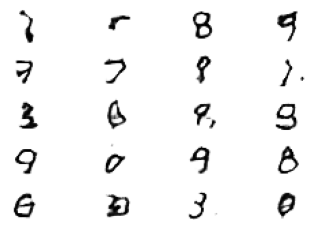

1/1 [==============================] - 0s 18ms/step - loss: 0.6884 - accuracy: 0.5333
Accuracy = 0.5333333611488342
fuck


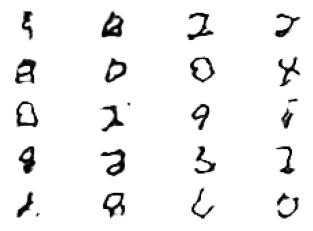

In [ ]:
train_gan(g,d,gan)